In [7]:
import os
import pulp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Importing from the src directory
from src.MOLP import MOLP, Solution
from src.NBI import NBI, plot_NBI_2D, plot_NBI_3D, plot_NBI_3D_to_2D
from src.nNBI import nNBI

# Set up the directories
code_dir = os.getcwd()
project_dir = os.path.dirname(code_dir)
data_dir = os.path.join(project_dir, 'data')



Objective values:
Total cost: 5000.0
Total deviation from current consumption: 4338.1066
Total CO2e: 0.3477536

Food items:
Noodles, egg, dry, enriched 208.48381
Bean, kidney, dried, raw 214.42
Leaf, amaranth, spiney, raw 90.003611
Pineapple, ripe 37.098151
Duck, liver, raw 20.585327
Fish, barb, pool, with bones, eyes included, raw 19.453304
Oil, vegetable 75.845576
NBI algorithm completed.


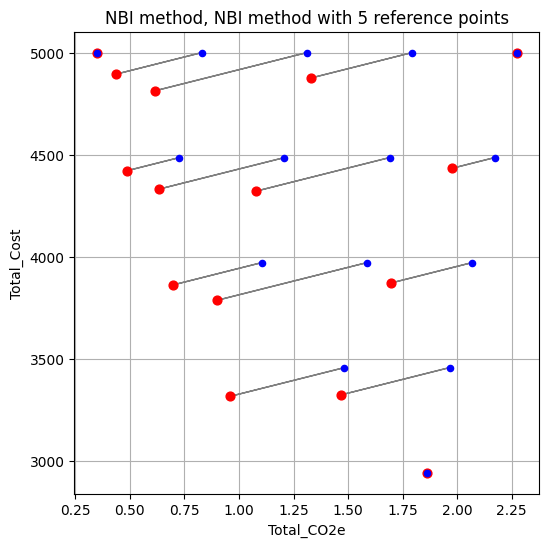

In [8]:
# Read data
nutritional_requirements_df = pd.read_excel(os.path.join(data_dir, 'female_nutritional_requirements.xlsx'), index_col=0, header=0)
food_items_cost_co2_intake_df = pd.read_excel(os.path.join(data_dir, 'food_items_cost_co2_intake.xlsx'), index_col=2, header=0)
food_items_nutritional_composition_df = pd.read_excel(os.path.join(data_dir, 'food_items_nutritional_composition.xlsx'), index_col=2, header=0)
food_groups_mean_intake_df = pd.read_excel(os.path.join(data_dir, 'food_groups_mean_intake.xlsx'), index_col=1, header=0)

# Data for the model
nutrients = list(nutritional_requirements_df.index)
nutrients.remove('Pantothenic acid (mg)') # Laking data for Pantothenic acid in the nutritional composition

food_items = list(food_items_cost_co2_intake_df.index)
food_groups = list(food_items_cost_co2_intake_df['Food group'].unique())
food_groups.remove('Condiments') # Remove condiments from the food groups as suggest Koenen 

# Nutritional requirements dictionary (min and max intake)
nutritional_requirements = {nutrient : {} for nutrient in nutrients}
for nutrient in nutrients:
    rni_value = nutritional_requirements_df.loc[nutrient, 'RNI']
    nutritional_requirements[nutrient]['min intake'] = np.float64(0) if pd.isna(rni_value) else rni_value
    ul_value = nutritional_requirements_df.loc[nutrient, 'UL']
    nutritional_requirements[nutrient]['max intake'] = 10*rni_value if pd.isna(ul_value) else ul_value

# Food items data dictionary (cost, co2, min and max intake)
food_items_data = {food_item : {} for food_item in food_items}
for food_item in food_items:
    food_item_dict = {}
    food_item_dict['cost'] = food_items_cost_co2_intake_df.loc[food_item, 'Cost (KHR/g)']
    food_item_dict['co2'] = food_items_cost_co2_intake_df.loc[food_item, 'CO2e (Kg/1000g)']
    food_item_dict['min intake'] = food_items_cost_co2_intake_df.loc[food_item, 'Min Intake (g)']
    food_item_dict['max intake'] = food_items_cost_co2_intake_df.loc[food_item, 'Max Intake (g)']
    food_items_data[food_item] = food_item_dict

# Food items nutrients dictionary (nutritional composition)
food_items_nutrients = {food_item : {} for food_item in food_items}
for food_item in food_items:
    food_item_dict = {}
    for nutrient in nutrients:
        food_item_dict[nutrient] = food_items_nutritional_composition_df.loc[food_item, nutrient]
    food_items_nutrients[food_item] = food_item_dict

# Food groups dictionary (mean intake and food items list)
food_groups_data = {food_group : {} for food_group in food_groups}
for food_group in food_groups:
    food_group_dict = {}
    food_group_dict['mean intake'] = food_groups_mean_intake_df.loc[food_group, 'Mean Intake (g)']
    food_group_dict['food items'] = list(food_items_cost_co2_intake_df[food_items_cost_co2_intake_df['Food group'] == food_group].index)
    food_groups_data[food_group] = food_group_dict

# Create the model
model = pulp.LpProblem('FoodBasketThreeObjectivesLP', pulp.LpMinimize)

# Variables
x = pulp.LpVariable.dicts('x', food_items, lowBound=0, cat='Continuous') # Amount of each food item
zlow = pulp.LpVariable.dicts('zlow', food_groups, lowBound=0, cat='Continuous') # Deviation below the current mean intake of each food group
zup = pulp.LpVariable.dicts('zup', food_groups, lowBound=0, cat='Continuous') # Deviation above the current mean intake of each food group

# Objectives (defined as variables)
f1 = pulp.LpVariable('Total Cost', lowBound=0, cat='Continuous') # Minimize cost
f2 = pulp.LpVariable('Total inadherence', lowBound=0, cat='Continuous') # Maximize adderence to current consumption
f3 = pulp.LpVariable('Total CO2e', lowBound=0, cat='Continuous') # Minimize CO2 emissions

# Objective function (defined as constraints, to be minimized)
model += f1 == pulp.lpSum([x[food_item] * food_items_data[food_item]['cost'] for food_item in food_items]) # Eq 5.1
model += f2 == pulp.lpSum([100 * (zlow[food_group] + zup[food_group]) / food_groups_data[food_group]['mean intake'] for food_group in food_groups]) # Eq 5.2
model += f3 == pulp.lpSum([(1/1000) * x[food_item] * food_items_data[food_item]['co2'] for food_item in food_items]) # Eq 5.3

# Constraints
for nutrient in nutrients:
    model += pulp.lpSum([(1/100) * x[food_item] * food_items_nutrients[food_item][nutrient] for food_item in food_items]) >= nutritional_requirements[nutrient]['min intake'] # Eq 5.4
    model += pulp.lpSum([(1/100) * x[food_item] * food_items_nutrients[food_item][nutrient] for food_item in food_items]) <= nutritional_requirements[nutrient]['max intake'] # Eq 5.5

for food_group in food_groups:
    model += pulp.lpSum([x[food_item] for food_item in food_groups_data[food_group]['food items']]) + zlow[food_group] >= food_groups_data[food_group]['mean intake'] # Eq 5.6
    model += pulp.lpSum([x[food_item] for food_item in food_groups_data[food_group]['food items']]) - zup[food_group] <= food_groups_data[food_group]['mean intake'] # Eq 5.7

for food_item in food_items:
    model += x[food_item] >= food_items_data[food_item]['min intake'] # Eq 5.8
    model += x[food_item] <= food_items_data[food_item]['max intake'] # Eq 5.9

model += f1 <= 5000

# List of objectives and variables
variables = [x[food_item] for food_item in food_items] + \
            [zlow[food_group] for food_group in food_groups] + \
            [zup[food_group] for food_group in food_groups]

objectives = [f1, f2, f3]

weights1 = [1, 0.000001, 0.000001]
weights2 = [0.000001, 1, 0.000001]
weights3 = [0.000001, 0.000001, 1]
weights = weights3

model += weights[0] * f1 + weights[1] * f2 + weights[2] * f3
model.solve()

# Results
print('Objective values:')
print('Total cost:', pulp.value(f1))
print('Total deviation from current consumption:', pulp.value(f2))
print('Total CO2e:', pulp.value(f3))

print('\nFood items:')
for food_item in food_items:
    if x[food_item].varValue > 0:
        print(food_item, x[food_item].varValue)

#----------------------------------------------
# Parameters
#----------------------------------------------
num_ref_points = 5

#----------------------------------------------
# Run the NBI algorithm
#----------------------------------------------


# Normalized NBI
# Create the NBI object (inherits from MOLP and adds the NBI algorithm)
nnbi = nNBI(model, objectives, variables)

nnbi.compute_all_individual_optima()

nnbi.normalize_objectives_and_individual_optima()

nnbi.normalized_NBI_algorithm(num_ref_points)

nnbi.denormalize_solutions()

#plot_NBI_3D(nnbi, normalize_scale=True)
plot_NBI_3D_to_2D(nnbi, objectives_to_use=[1,0,1], normalize_scale=True, swap_axes=True)

<Axes: >

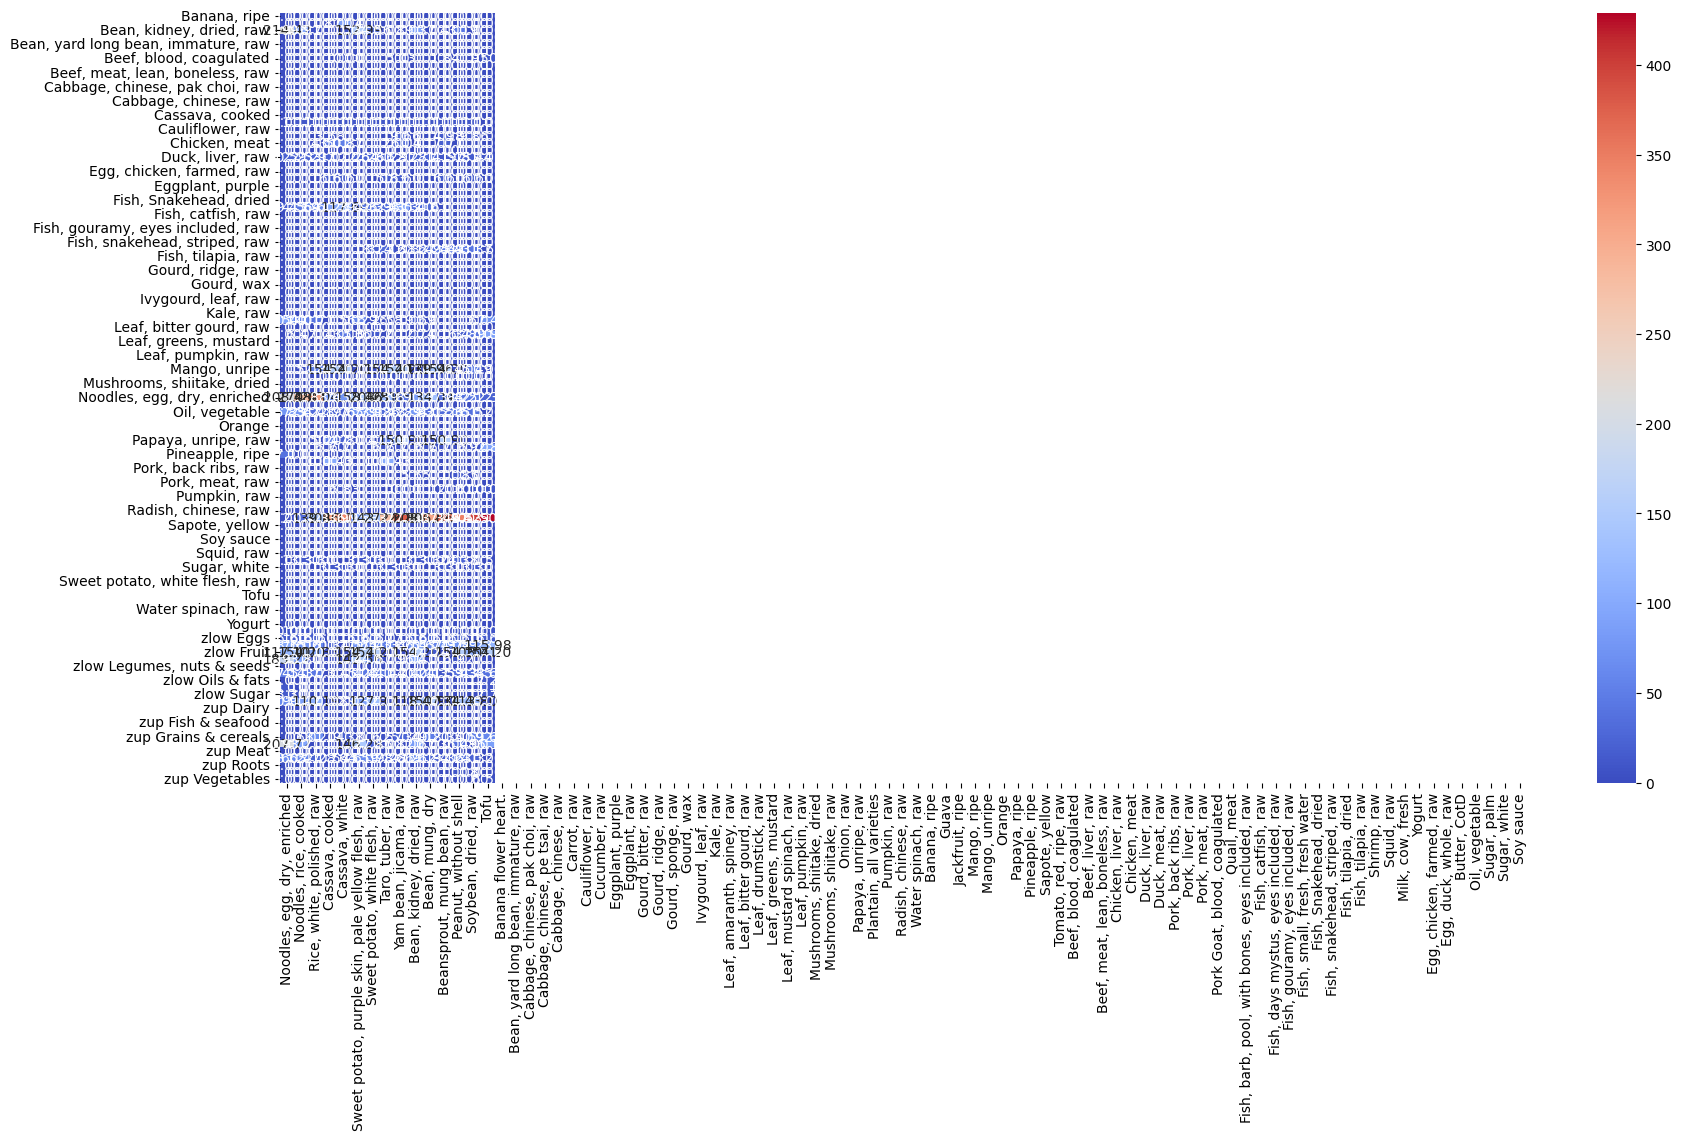

In [48]:
from copy import deepcopy
import seaborn as sns

results = deepcopy(nnbi)

results.solutions_dict

food_items = list(food_items_cost_co2_intake_df.index)

results_variable_dict = {}
for i, sol in results.solutions_dict.items():
    results_variable_dict[i] = sol.variable_dict()

# results_variable_dict to df
results_df = pd.DataFrame(results_variable_dict).T
# Remove 'x_' and all '_' from the column names
results_df.columns = results_df.columns.str.replace('x_', '').str.replace('_', ' ')

column_names = list(results_df.columns)
food_items = food_items
# Replace '/' with ' ' in food_items
food_items = [food_item.replace('/', ' ') for food_item in food_items]

#Heat map of results_df
plt.figure(figsize=(20, 10))
sns.heatmap(results_df[column_names].T, cmap='coolwarm', annot=True, fmt=".2f", xticklabels=food_items)



In [45]:
one_sol = results.individual_optima[0]

var = one_sol.variable_dict()

# Some key (food) contain 'blood' in their name?
for i in var.keys():
    print(i)

x_Noodles,_egg,_dry,_enriched
x_Noodles,_rice,_cooked
x_Rice,_white,_polished,_raw
x_Cassava,_cooked
x_Cassava,_white
x_Sweet_potato,_purple_skin,_pale_yellow_flesh,_raw
x_Sweet_potato,_white_flesh,_raw
x_Taro,_tuber,_raw
x_Yam_bean,_jicama,_raw
x_Bean,_kidney,_dried,_raw
x_Bean,_mung,_dry
x_Beansprout,_mung_bean,_raw
x_Peanut,_without_shell
x_Soybean,_dried,_raw
x_Tofu
x_Banana_flower_heart.
x_Bean,_yard_long_bean,_immature,_raw
x_Cabbage,_chinese,_pak_choi,_raw
x_Cabbage,_chinese,_pe_tsai,_raw
x_Cabbage,_chinese,_raw
x_Carrot,_raw
x_Cauliflower,_raw
x_Cucumber,_raw
x_Eggplant,_purple
x_Eggplant,_raw
x_Gourd,_bitter,_raw
x_Gourd,_ridge,_raw
x_Gourd,_sponge,_raw
x_Gourd,_wax
x_Ivygourd,_leaf,_raw
x_Kale,_raw
x_Leaf,_amaranth,_spiney,_raw
x_Leaf,_bitter_gourd,_raw
x_Leaf,_drumstick,_raw
x_Leaf,_greens,_mustard
x_Leaf,_mustard_spinach,_raw
x_Leaf,_pumpkin,_raw
x_Mushrooms,_shiitake,_dried
x_Mushrooms,_shiitake,_raw
x_Onion,_raw
x_Papaya,_unripe,_raw
x_Plantain,_all_varieties
x_Pumpkin,_r

In [ ]:

variable_dict = {}
for food_item in food_items:
    variable_dict[food_item] = [solution.variable_values()[food_item] for solution in results.solutions_dict.values()]

# Dataframe with solutuions q as columns and variables (food items) as rows
solutions_df = pd.DataFrame(index=food_items)
for q, solution in results.solutions_dict.items():
    solutions_df[q] = [solution.variable_values() for food_item in food_items]
solutions_df